<a href="https://colab.research.google.com/github/OSGeoLabBp/tutorials/blob/master/english/data_processing/lessons/circle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Regression circle

How can ve fit a circle on four or more points?

First let's try the least squares method (LSM) to find a solution.

Unfortunately the equations are not linear, but we can change it to a quadratic equation of a single variable:

${(x - x_0)}^{2} + {(y - y_0)}^{2} = r^2$

We have x and y positions of points on the circle, and we would like to find $x_0, y_0, r$.
Removing the bracket we get:

$x^2 - 2 x x_0 + {x_0}^2 + y^2 -2 y y_0 + {y_0}^2 = r^2$

Let's reorder the tags:

$y^2 + x^2  -2 x_0 x -2 y_0 y + x_0^2 + y_0^2 -r^2 = 0$

Lest substitute the unknowns:

$a_1 = -2 x_0$

$a_2 = -2 y_0$

$a_3 = x_0^2 + y_0^2 - r^2$

$x a_1 + y a_2 + a_3 =  -(x^2 + y^2)$

So we get a linear equation of three unknowns $a_1, a_2, a_3$ for each measured points, 
which is solved using numpy.

In [30]:
from math import sqrt, pi, sin, cos
import numpy as np
# sample data
x = np.array([ 11.88, 10.34, 2.58, -0.29, 5.1 ])
y = np.array([  0.08,  8.59, 9.54,  1.95, -2.3 ])

Setting up and solving the equation system

In [31]:
# coefficients of unknowns
a = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
# pure term
b = -(x * x + y * y)
# solution for a1, a2, a3
par = np.linalg.lstsq(a, b, rcond=None)
x0 = -0.5 * par[0][0]
y0 = -0.5 * par[0][1]
r = sqrt(x0**2 + y0**2 - par[0][2])
# residuals
res = np.sqrt((x - x0)**2 + (y - y0)**2) -r
print(f"(x - {x0:.3f})^2 + (y - {y0:.3f})^2 = {r:.3f}")
print("residuals:")
print([f"{v:.3f} " for v in res])

(x - 6.123)^2 + (y - 3.868)^2 = 6.576
residuals:
['0.315 ', '-0.245 ', '0.112 ', '0.118 ', '-0.323 ']


Let's display points and circle

Best fitting circle


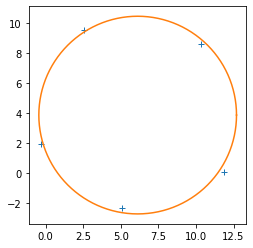

In [32]:
import matplotlib.pyplot as plt
plt.plot(x, y, '+')
plt.plot([x0 + r * cos(alfa / 180 * pi) for alfa in range(0, 361)],
         [y0 + r * sin(alfa / 180 * pi) for alfa in range(0, 361)])
plt.axis('scaled')
print("Best fitting circle")

# Robust estimation of parameters using RANSAC

What happens if we have an outlier among the points? If we have few points we can find outlier from a figure or we can use data snooping. Using laser scenners or photogrammetry we get point clouds where there are huge number of points and usually many outliers.

This case Random Sample Consensus (RANSAC) comes into the view.

In [33]:
# circle through points
def circle(x, y):
    # coefficients of unknowns
    a = np.stack((x, y, np.full(x.size, 1.0)), axis=1)
    # pure term
    b = -(x * x + y * y)
    # solution for a1, a2, a3
    par = np.linalg.lstsq(a, b, rcond=None)
    x0 = -0.5 * par[0][0]
    y0 = -0.5 * par[0][1]
    r = sqrt(x0**2 + y0**2 - par[0][2])
    return x0, y0, r

In [34]:
# circle throug three points
circle(x[0:3], y[0:3])

(5.762471327735672, 3.367292108661916, 6.944814357752633)

(-11.583014348592059,
 11.645780808548812,
 -11.644406720128728,
 11.510914716115682)

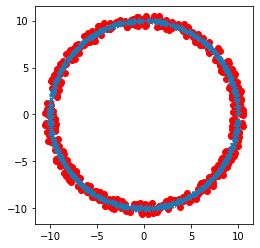

In [35]:
# generating test data
from random import random, seed, randint
seed()
# random points on circle
n = 1000    # number of points on the circle
m = 500     # number of outlier points 
r_range = 0.2
r_base = 10.0
x = np.zeros(n+m)
y = np.zeros(n+m)
for i in range(n):
    alpha = random() * pi * 2   # angle between 0-360 degre in radians
    r = r_base + (random() - 0.5) * r_range   # random radius
    x[i] = r * sin(alpha)
    y[i] = r * cos(alpha)
for i in range(n, n+m):
    alpha = random() * pi * 2   # angle between 0-360 degre in radians
    r = r_base + (random() - 0.5) * 6 * r_range
    x[i] = r * sin(alpha)
    y[i] = r * cos(alpha)
plt.plot(x[n:n+m], y[n:n+m], 'ro')
plt.plot(x[:n], y[:n], '+')
plt.axis('scaled')

In [53]:
# RANSAC
n_try = 100
best = 0
print("  center x   center y     radius    fit iter")
for i in range(n_try):
    index = [randint(0, n+m-1) for i in range(3)]    # three random index
    x3 = x[index]   # three random points
    y3 = y[index]
    xc, yc, r3 = circle(x3, y3)
    # distance from the circle
    dist = np.abs(np.sqrt((x - xc)**2, (y - yc)**2) - r3)
    n_fit = dist[dist < r_range/2].size
    print(index, i, n_fit)
    if n_fit > best:
        best = n_fit
        best_xc = xc
        best_yc = yc
        best_r = r3
        print(TODO)

  center x   center y     radius    fit iter
[702, 549, 595] 0 52
[629, 1179, 99] 1 103
[930, 169, 290] 2 90
[514, 963, 974] 3 38
[606, 470, 870] 4 58
[559, 986, 9] 5 78
[561, 69, 1472] 6 0
[1468, 1283, 327] 7 11
[587, 967, 327] 8 37
[408, 36, 161] 9 61
[458, 1482, 261] 10 49
[1280, 260, 1428] 11 47
[738, 1051, 756] 12 37
[364, 547, 194] 13 49
[1311, 511, 982] 14 30
[718, 7, 74] 15 99
[1395, 1251, 1097] 16 16
[79, 1287, 893] 17 69
[438, 1325, 822] 18 79
[872, 1066, 189] 19 45
[810, 715, 1478] 20 58
[456, 450, 806] 21 96
[792, 276, 992] 22 64
[449, 162, 329] 23 49
[585, 66, 538] 24 6
[1183, 1217, 438] 25 33
[827, 961, 808] 26 100
[745, 1414, 803] 27 8
[1376, 1461, 1107] 28 4
[252, 518, 937] 29 81
[1253, 410, 1260] 30 41
[430, 265, 1159] 31 47
[742, 530, 838] 32 104
[1316, 785, 558] 33 96
[1334, 597, 988] 34 95
[1257, 931, 697] 35 32
[527, 1407, 654] 36 63
[705, 420, 591] 37 76
[979, 1220, 580] 38 32
[1346, 1287, 433] 39 100
[209, 32, 1059] 40 0
[582, 494, 1378] 41 30
[782, 497, 648] 42 

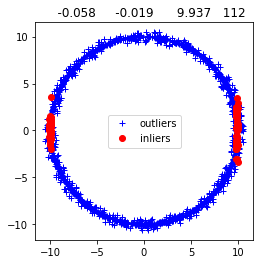

In [48]:
# plot result
plt.title(f"{best_xc:10.3f} {best_yc:10.3f} {best_r:10.3f} {best:5d}")
plt.plot([best_xc + best_r * cos(alfa / 180 * pi) for alfa in range(0, 361)],
         [best_yc + best_r * sin(alfa / 180 * pi) for alfa in range(0, 361)])
dist = np.abs(np.sqrt((x - best_xc)**2, (y - best_yc)**2) - best_r)
plt.plot(x[dist >= r_range/2], y[dist >= r_range/2], "b+", label='outliers')
plt.plot(x[dist < r_range/2], y[dist < r_range/2], "ro", label="inliers")
plt.axis('scaled')
plt.legend()